# Quantum-Classical Convolutional Neural Networks (QCCNN) for detecting hand-written digits

0. Import the necessary packages and the QC_CNN class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from qat.lang.AQASM import Program, H, RX, RY, RZ, CNOT
from qat.qpus import get_default_qpu, PyLinalg
from qat.core import Observable, Term
from qat.plugins import ObservableSplitter
#from qlmaas.qpus import LinAlg # Comment when using myQLM

import myQML


1. Load the MNIST dataset, selecting the number of training and test images, and then normalize the image pixels to values between 0 and 1.

In [2]:
n_training_images = 200
n_test_images = 50

mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_training_images]
train_labels = train_labels[:n_training_images]
test_images = test_images[:n_test_images]
test_labels = test_labels[:n_test_images]

train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
n_shots = None # Number of shots for the quantum circuit. If None, it will use the default number of shots defined in the QPU.
device = 'myqlm'  # or 'myqlm' or qaptiva'
length_image = 28  # Length of the image (28x28 pixels)
n_qubits = 4 # Number of qubits in the quantum convolutional kernel
n_blocks = 3  # Number of blocks in the quantum convolutional kernel
n_params = 3*n_qubits*n_blocks # Number of parameters in the quantum convolutional kernel
params = np.random.rand(n_params) * np.pi  # Random parameters for the quantum circuit

def quantum_conv_kernel_circuit(a):
    angle_encoding = myQML.Angle_Encoding(n_qubits)
    qprogram, qubits = angle_encoding.get_quantum_program(a)
    
    for b in range(n_blocks):
        for i, qubit in enumerate(qubits):
            qprogram.apply(RZ(params[3 * (i + b * n_qubits)]), qubit)
            qprogram.apply(RX(params[3 * (i + b * n_qubits) + 1]), qubit)
            qprogram.apply(RZ(params[3 * (i + b * n_qubits) + 2]), qubit)
        for i, qubit in enumerate(qubits):
            if (i + 1 + b) % n_qubits != i:
                qprogram.apply(CNOT, qubit, qubits[(i + b + 1) % n_qubits])
            else:
                qprogram.apply(CNOT, qubit, qubits[(i + 1) % n_qubits])
    
    circuit = qprogram.to_circ()

    expected_z_values = np.zeros(n_qubits)

    for i in range(n_qubits):
        obs = Observable(n_qubits)
        obs.add_term(Term(1, "Z", [i]))

        # Submit the circuit to the QPU, measuring the expectation value of the observable
        if device.lower() == 'qaptiva':
            qpu = ObservableSplitter() | LinAlg()
        elif device.lower() == 'myqlm':
            qpu = ObservableSplitter() | PyLinalg()
        else:
            raise ValueError(f'Unknown device: {device}')

        # Create a quantum job and use a finite number if it is specified in the class instance
        if n_shots is None:
            job = circuit.to_job("OBS", observable=obs)
        else:
            job = circuit.to_job("OBS", observable=obs, nbshots=n_shots)

        # Submit the job and obtain the probability of measuing all qubits in state 0
        expected_z_values[i] = qpu.submit(job).value

    return expected_z_values

def quantum_conv_layer(image):
    '''
    Slides the quantum convolutional kernel over the image and applies the quantum circuit to each 2x2 region, and generates 4 channels of output.
    '''

    output_image = np.zeros((length_image//2, length_image//2, 4))

    # Iterate over the pixels of the original image in steps of 2
    for j in range(0, length_image, 2):
        for k in range(0, length_image, 2):
            # Evaluates the quantum circuit on the 2x2 region of the image
            q_results = quantum_conv_kernel_circuit([image[j, k, 0], image[j, k + 1, 0], image[j + 1, k, 0], image[j + 1, k + 1, 0]])
            
            # Each qubit expectation value corresponds to a channel in the output image
            for c in range(4):
                output_image[j // 2, k // 2, c] = q_results[c]

    return output_image

def quantum_conv_preprocessing(train_images, test_images):
    '''
    Applies the quantum convolutional layer to each image in the dataset.
    '''

    quantum_train_images = np.asarray([quantum_conv_layer(image=img) for img in train_images])
    quantum_test_images = np.asarray([quantum_conv_layer(image=img) for img in test_images])

    return quantum_train_images, quantum_test_images
    
quantum_train_images, quantum_test_images = quantum_conv_preprocessing(train_images, test_images)


In [20]:
print(train_images.shape)
print(quantum_train_images.shape)

(200, 28, 28, 1)
(200, 14, 14, 4)


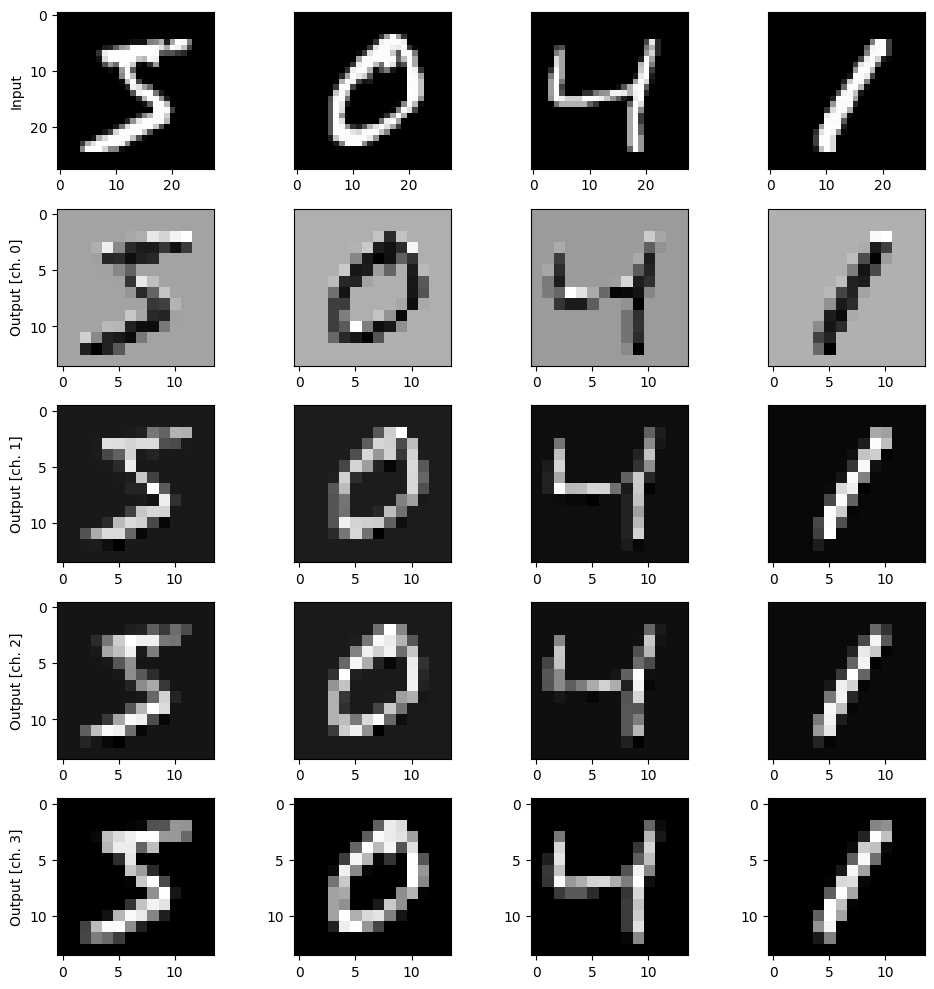

In [4]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(quantum_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [16]:
def Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    
    model = tf.keras.models.Sequential([

        # First convolutional layer
        tf.keras.layers.Conv2D(filters=50, kernel_size=(2, 2), activation='relu'),
                
        # First pooling layer
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Second convolutional layer
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
        
        # Second pooling layer
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten to feed into dense layer
        tf.keras.layers.Flatten(),
        
        # Fully connected dense layer
        tf.keras.layers.Dense(64, activation='relu'),
        
        # Final output layer with 10 units for classification
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [17]:
q_model = Model()
n_epochs = 50

#q_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta = 1e-4, restore_best_weights = True)

q_history = q_model.fit(
    quantum_train_images,
    train_labels,
    validation_data=(quantum_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2#,
    #callbacks=[q_early_stop]
)

Epoch 1/50
50/50 - 5s - 97ms/step - accuracy: 0.1100 - loss: 2.2969 - val_accuracy: 0.0800 - val_loss: 2.2399
Epoch 2/50
50/50 - 1s - 15ms/step - accuracy: 0.3450 - loss: 2.1127 - val_accuracy: 0.4400 - val_loss: 1.9267
Epoch 3/50
50/50 - 1s - 13ms/step - accuracy: 0.5700 - loss: 1.4948 - val_accuracy: 0.6200 - val_loss: 1.3379
Epoch 4/50
50/50 - 1s - 13ms/step - accuracy: 0.7950 - loss: 0.8426 - val_accuracy: 0.6200 - val_loss: 1.2460
Epoch 5/50
50/50 - 1s - 13ms/step - accuracy: 0.8550 - loss: 0.5788 - val_accuracy: 0.6400 - val_loss: 1.1418
Epoch 6/50
50/50 - 1s - 15ms/step - accuracy: 0.8950 - loss: 0.4397 - val_accuracy: 0.6800 - val_loss: 0.9727
Epoch 7/50
50/50 - 1s - 21ms/step - accuracy: 0.9300 - loss: 0.3153 - val_accuracy: 0.7600 - val_loss: 0.7611
Epoch 8/50
50/50 - 1s - 15ms/step - accuracy: 0.9600 - loss: 0.1888 - val_accuracy: 0.8000 - val_loss: 0.6875
Epoch 9/50
50/50 - 1s - 15ms/step - accuracy: 0.9800 - loss: 0.1312 - val_accuracy: 0.8000 - val_loss: 0.6690
Epoch 10/5

In [18]:
c_model = Model()

#early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta = 1e-4, restore_best_weights = True)

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2#,
    #callbacks=[early_stop]
)

Epoch 1/50
50/50 - 6s - 114ms/step - accuracy: 0.3500 - loss: 2.0183 - val_accuracy: 0.4600 - val_loss: 1.5998
Epoch 2/50
50/50 - 1s - 21ms/step - accuracy: 0.7700 - loss: 0.8476 - val_accuracy: 0.8400 - val_loss: 0.7471
Epoch 3/50
50/50 - 1s - 23ms/step - accuracy: 0.8800 - loss: 0.3784 - val_accuracy: 0.8600 - val_loss: 0.5962
Epoch 4/50
50/50 - 1s - 19ms/step - accuracy: 0.9550 - loss: 0.1746 - val_accuracy: 0.7800 - val_loss: 0.7149
Epoch 5/50
50/50 - 1s - 22ms/step - accuracy: 0.9700 - loss: 0.1151 - val_accuracy: 0.8400 - val_loss: 0.5873
Epoch 6/50
50/50 - 2s - 31ms/step - accuracy: 0.9950 - loss: 0.0480 - val_accuracy: 0.8200 - val_loss: 0.5734
Epoch 7/50
50/50 - 1s - 27ms/step - accuracy: 0.9950 - loss: 0.0251 - val_accuracy: 0.8800 - val_loss: 0.6078
Epoch 8/50
50/50 - 1s - 24ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.8800 - val_loss: 0.6290
Epoch 9/50
50/50 - 1s - 19ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.8800 - val_loss: 0.6652
Epoch 10/

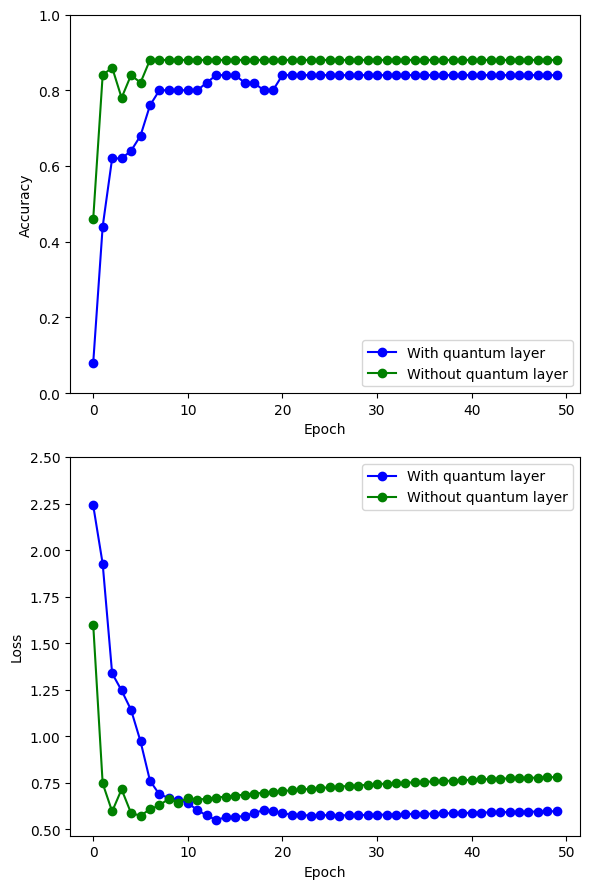

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()